# Grab Gaia data and format it for Firefly

Create a conda env

```
conda create --name Gaia python=3.10 astropy astroquery jupyter scipy numpy matplotlib pandas h5py eventlet flask flask-socketio requests
```


In [60]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from astroquery.gaia import Gaia
from astropy.table import Table, Column
import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS
from astropy.io import ascii

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
GaiaCatalog = "gaiaedr3.gaia_source" 

In [233]:
N = 1e7
gmax = 12
columns = 'ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag, bp_rp'

cmd = f"SELECT TOP {int(N)} {columns} \
FROM {GaiaCatalog} \
WHERE phot_g_mean_mag<={gmax} \
AND parallax IS NOT NULL \
AND dr2_radial_velocity IS NOT NULL"
print(cmd)

#synchronous commands are OK for jobs with < 2000 output rows
#job = Gaia.launch_job(cmd, dump_to_file=False) 

#asynchronous commands for larger files
job = Gaia.launch_job_async(cmd, dump_to_file=False)

print(job)

SELECT TOP 10000000 ra, dec, parallax, pmra, pmdec, dr2_radial_velocity, phot_g_mean_mag, bp_rp FROM gaiaedr3.gaia_source WHERE phot_g_mean_mag<=12 AND parallax IS NOT NULL AND dr2_radial_velocity IS NOT NULL
INFO: Query finished. [astroquery.utils.tap.core]
<Table length=2346497>
        name         dtype    unit                  description                 n_bad
------------------- ------- -------- ------------------------------------------ -----
                 ra float64      deg                            Right ascension     0
                dec float64      deg                                Declination     0
           parallax float64      mas                                   Parallax     0
               pmra float64 mas / yr Proper motion in right ascension direction     0
              pmdec float64 mas / yr     Proper motion in declination direction     0
dr2_radial_velocity float32   km / s              Radial velocity from Gaia DR2     0
    phot_g_mean_mag float32   

In [234]:
GaiaData = job.get_results()
GaiaData

ra,dec,parallax,pmra,pmdec,dr2_radial_velocity,phot_g_mean_mag,bp_rp
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag
float64,float64,float64,float64,float64,float32,float32,float32
282.717638809954,5.678589256718091,4.895651948510564,12.920215499221381,-12.157485102325001,-17.226954,10.219143,0.7910309
285.42400750687676,5.748524590289011,2.8097993718125878,4.172226577840751,-2.456463325250668,10.045121,11.459485,0.8224335
283.2253084293333,5.985893578742719,4.797513455035142,40.134645201165604,-23.7457194885826,22.376074,9.865556,0.7161522
258.16921472992595,-19.17551233809951,0.5471487465757905,1.2252572441859229,4.034427556941061,-20.605927,9.423732,2.068554
276.6671334933571,-23.36800196727716,0.4779239568776744,6.537071073496116,-2.8653532839112232,-39.64584,11.350695,1.9902363
258.1501377276725,-19.157169294215578,0.43959325118390113,1.390618364094999,-4.666901669568685,-26.035835,11.965985,1.837017
285.4302610444678,5.8185759796736205,2.626231713942302,-12.53273381974123,-9.01000902914774,6.69268,11.756206,0.95399
282.7946127450585,5.790625549362154,1.2784787006805898,-2.5938735193501694,-9.114955094605095,3.0134463,11.737728,2.06361


## Convert these ra, dec, parallax coordinates to 3D cartesian

A better way may be to use the Bailer-Jones distances...

In [235]:
mask = ( (GaiaData['parallax'] > 0) &
         ~np.isnan((GaiaData['parallax'])) &
         ~np.isnan((GaiaData['phot_g_mean_mag'])) &
         ~np.isnan((GaiaData['bp_rp'])) &
         ~np.isnan((GaiaData['dr2_radial_velocity'])) 
       )
useGaiaData = GaiaData[mask]

In [236]:
coordsRV = ICRS(ra = useGaiaData['ra'], 
              dec = useGaiaData['dec'], 
              distance = (useGaiaData['parallax']).to(u.parsec, equivalencies=u.parallax()),
              pm_ra_cosdec = useGaiaData['pmra'],
              pm_dec = useGaiaData['pmdec'], 
              radial_velocity = useGaiaData['dr2_radial_velocity'])
#print(coordsRV.cartesian)
#print(coordsRV.velocity)

In [237]:
outdfRV = pd.DataFrame()
outdfRV['x'] = coordsRV.cartesian.x.value
outdfRV['y'] = coordsRV.cartesian.y.value
outdfRV['z'] = coordsRV.cartesian.z.value
outdfRV['vx'] = coordsRV.velocity.d_x.value
outdfRV['vy'] = coordsRV.velocity.d_y.value
outdfRV['vz'] = coordsRV.velocity.d_z.value
outdfRV['bp_rp'] = np.array(useGaiaData['bp_rp'].data)
outdfRV['phot_g_mean_mag'] = np.array(useGaiaData['phot_g_mean_mag'].data)
outdfRV

,x,y,z,vx,vy,vz,bp_rp,phot_g_mean_mag
0,44.747089,-198.273863,20.211384,8.686336,18.339788,-13.418920,0.791031,10.219143
1,94.178458,-341.354005,35.647542,9.554099,-8.162692,-3.117365,0.822433,11.459485
2,47.427379,-201.806657,21.737012,44.256740,-14.972933,-21.001991,0.716152,9.865556
3,-353.919672,-1689.582263,-600.317558,12.026454,5.635547,39.783008,2.068554,9.423732
4,223.001941,-1907.768735,-829.912968,58.867778,54.872438,-10.364953,1.990236,11.350695
...,...,...,...,...,...,...,...,...
2344537,-1234.699284,-301.921740,-2261.331976,-23.074748,132.772969,49.683330,2.006218,11.910892
2344538,-692.277165,-202.976038,-1244.584484,1.860059,53.555927,-2.099770,1.668958,11.683310
2344539,-480.489885,-141.519115,-861.667748,3.072682,33.529618,1.114667,1.655364,11.773745
2344540,-136.369876,-39.308765,-245.326095,-6.147136,-10.556231,-18.552521,1.593614,8.536899


In [238]:
# export this to a csv file for now
outdfRV.to_csv('tmpGaia.csv')

In [239]:
from firefly.data_reader import ArrayReader

(array([ 2.,  7., 15., 13., 18., 18., 14.,  6.,  4.,  3.]),
 array([1.55622705, 2.05395579, 2.55168452, 3.04941326, 3.547142  ,
        4.04487074, 4.54259948, 5.04032822, 5.53805696, 6.0357857 ,
        6.53351444]),
 <BarContainer object of 10 artists>)

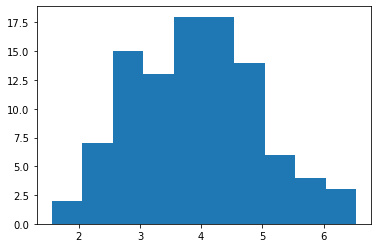

In [265]:

plt.hist(temps)

In [277]:
from scipy.interpolate import interp1d

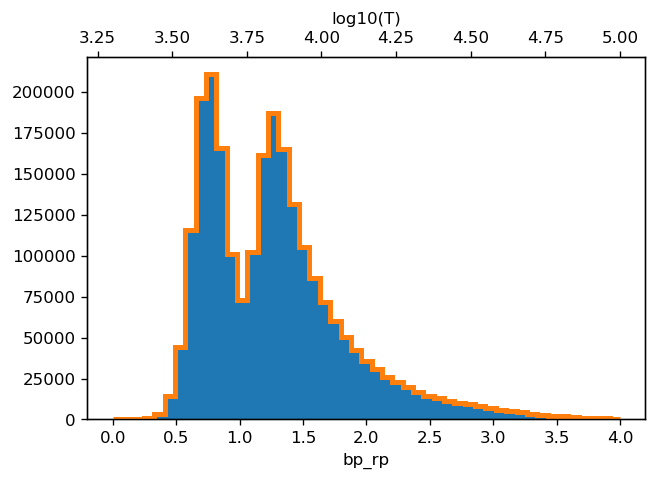

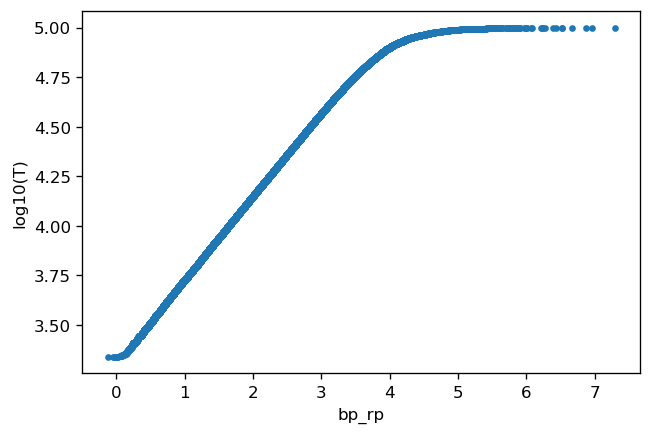

In [309]:
import matplotlib.pyplot as plt
%matplotlib inline

def remap_nonparametrically(values,old_interval,new_interval):
    h,_ = np.histogram(values,bins=np.linspace(*old_interval))
    new_edges = np.linspace(*new_interval)
    probs = np.cumsum(h)/np.sum(h)
    probs[0] = 0
    inverter = interp1d(probs,temp_edges[1:])
    new_values = inverter(np.random.uniform(0,1,df.shape[0]))
    
    sort_indices = np.argsort(values)
    new_values = np.sort(new_values)[np.argsort(sort_indices)]
    return new_values
    
    

old_interval = (0,4)
new_interval = (np.log10(2e3),5)

h,edges,p = plt.hist(df['bp_rp'],bins=np.linspace(*old_interval))
ax1 = plt.gca()
ax2 = ax1.twiny()
temps = remap_nonparametrically(df['bp_rp'],old_interval,new_interval)
ax2.hist(temps,bins=np.linspace(*new_interval),histtype='step',color='C1',lw=3)

ax1.set_xlabel('bp_rp')
ax2.set_xlabel('log10(T)')
plt.gcf().set_facecolor('white')
plt.gcf().set_dpi(120)

plt.figure()
plt.plot(bp_rps,temps,'.')
plt.gca().set_ylabel('log10(T)')
plt.gca().set_xlabel('bp_rp')
plt.gcf().set_dpi(120)
plt.gcf().set_facecolor('white')

0.984375

In [240]:
df = pd.read_csv('tmpGaia.csv')
coordinates = np.zeros((df.shape[0],3))
velocities = np.zeros((df.shape[0],3))

for i,axis in enumerate(['x','y','z']):
    coordinates[:,i] = df[axis]
    velocities[:,i] = df[f'v{axis}']
coordinates

array([[  44.74708905, -198.27386341,   20.21138422],
       [  94.1784582 , -341.35400452,   35.64754174],
       [  47.42737877, -201.80665677,   21.73701154],
       ...,
       [-480.48988524, -141.51911534, -861.66774804],
       [-136.36987599,  -39.3087655 , -245.32609517],
       [-498.94824416, -146.43772507, -892.23702308]])

In [311]:
fields = {key:df[key].to_numpy() for key in ['bp_rp','phot_g_mean_mag']}
fields['minus_mag'] = -fields['phot_g_mean_mag']
fields['log10Temperature'] = temps
for key,value in fields.items():
    print(key,np.min(value),np.max(value))


bp_rp -0.1259861 7.2997017
phot_g_mean_mag 2.4740036 12.0
minus_mag -12.0 -2.4740036
log10Temperature 3.3372207063318906 4.999980577312683


In [321]:
reader = ArrayReader(
    ## don't have to pass as a list with 1 element 
    ##  if only 1 particle group
    coordinates,
    velocities,
    'eDR3-RV',
    fields,
    JSONdir='GaiaeDR3', ## if not an absolute path assumes from ~
    clean_JSONdir=True, ## delete old files in the directory
    write_startup=True, ## overwrite the startup file (and turn off PG append)
    write_to_disk=False, ## whether to write to disk at the end of __init__
    field_filter_flags=[True,True,False,True], ## flags corresponding to fields
    field_colormap_flags=[True,True,False,True],
    field_radius_flags=[False,False,True,False],
)

reader.settings['sizeMult']['eDR3-RV'] = 1
#reader.settings['radiusVariable']['eDR3-RV'] = 1

## pick the last colormap, blackbody
index = (256/8-1)
reader.settings['colormap']['eDR3-RV'] = (index + 0.5) * (8/256)
reader.settings['colormapVariable']['eDR3-RV'] = 2
reader.settings['showColormap']['eDR3-RV'] = True
reader.settings['GUIExcludeList'] = [
    'eDR3-RV/dropdown/colormap',
    'eDR3-RV/colorPicker',
    'eDR3-RV/dropdown/general/radiusVariableSelector']


reader.writeToDisk()

JSONdir: /Users/agurvich/GaiaeDR3 -- is not a sub-directory of firefly/static/data. 
This may produce confusing or inoperable results. As such, we will create a symlink for you when you writeToDisk.
filter/colormap/radius flags correspond to: ['bp_rp', 'phot_g_mean_mag', 'minus_mag', 'log10Temperature']
Outputting: eDR3-RV - 2344542/2344542 particles - 5 tracked fields


''

In [324]:
reader.copyFireflySourceToTarget('Gaia_test',init_gh_pages=False,overwrite=True,dump_data=True)

['/Users/agurvich/Gaia_test']

In [ ]:
reader.createOctrees([True],npart_min_node=1e4,npart_max_node=1e5)

In [ ]:
## symlink = False -> data will be copied to static/data
reader.writeToDisk(symlink=False)